# Crack Detection 



### Data Preprocessing and Visualization

Let's start by loading the dataset and visualizing random images with bounding boxes.



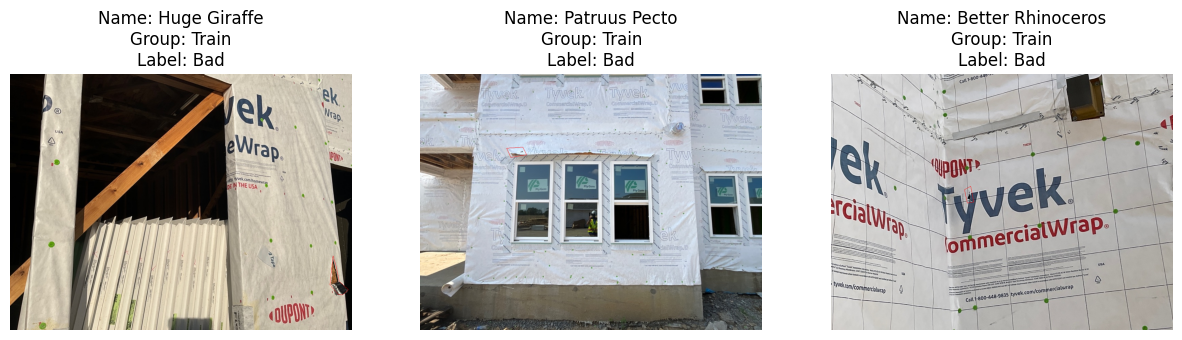

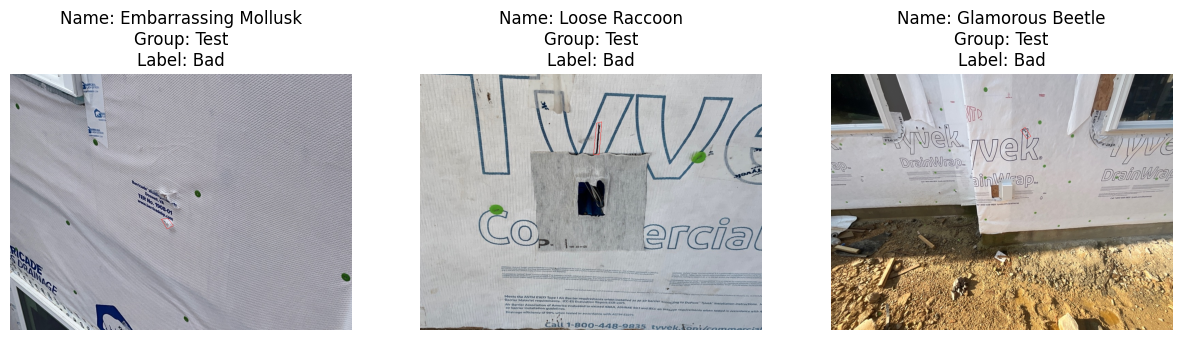

In [1]:
import os
import pandas as pd
import random
import requests
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Read the dataset
# data = pd.read_excel('WRB_trimmed.xlsx')
data = pd.read_excel('WRB_All.xlsx')

# Split the data into training and test sets based on the 'Group Name' column
train_data = data[data['Group Name'] == 'Train']
test_data = data[data['Group Name'] == 'Test']


def fetch_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def draw_bounding_box(image, points):
    draw = ImageDraw.Draw(image)
    bbox = [(point['x'], point['y']) for point in eval(points)]
    draw.polygon(bbox, outline="red")
    return image

def visualize_random_images(data, n=3):
    samples = data.sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img = fetch_image(row['2D Image URL'])
        img = draw_bounding_box(img, row['2D Image Points'])
        axes[i].imshow(img)
        axes[i].set_title(f"Name: {row['Name']}\nGroup: {row['Group Name']}\nLabel: {row['Label']}")
        axes[i].axis('off')

# Visualize random images from the training and test set
visualize_random_images(train_data)
visualize_random_images(test_data)


### Authenticate the client

Instantiate a training and prediction client with your endpoint and keys. 

In [2]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
print(os.getenv("TRAINING_KEY"), os.getenv("TRAINING_ENDPOINT"))

# Authentication
credentials = ApiKeyCredentials(in_headers={"Training-key": os.getenv("TRAINING_KEY")})
trainer = CustomVisionTrainingClient(endpoint=os.getenv("TRAINING_ENDPOINT"), credentials=credentials)

# Authentication for prediction
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": os.getenv("PREDICTION_KEY")})
predictor = CustomVisionPredictionClient(endpoint=os.getenv("PREDICTION_ENDPOINT"), credentials=prediction_credentials)


90dad624b6664556accbcfd69e2e170d https://crackdetection.cognitiveservices.azure.com/


### Creat or get the project

In [3]:
# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Project name setup
project_name = "WRB-Bad-Detection"

# Find project by name
print(f"Searching for project '{project_name}'...")
projects = trainer.get_projects()

project_id = None
for project in projects:
    if project.name == project_name:
        project_id = project.id
        break

if project_id:
    print(f"Project '{project_name}' found with ID: {project_id}")
else:
    print(f"No project found with the name '{project_name}'")
    # Create a new project
    print ("Creating project...")
    project = trainer.create_project(project_name, domain_id=obj_detection_domain.id)


Searching for project 'WRB-Bad-Detection'...
Project 'WRB-Bad-Detection' found with ID: 1ee0bb48-3b3f-419d-a575-e12c98f91578


### Data Ingestion and Transformation

Create a data pipeline to transform and ingest data according to Azure Custom Vision's requirements.

In [15]:
from azure.cognitiveservices.vision.customvision.training.models import Region, ImageUrlCreateEntry, ImageUrlCreateBatch
from tqdm import tqdm
import json

# Create tags in Custom Vision
tag_dict = {}
for label in data['Label'].unique():
    tag_dict[label] = trainer.create_tag(project.id, label)

# Function to convert polygon to bounding box
def polygon_to_bbox(polygon):
    x_coords = [point['x'] for point in polygon]
    y_coords = [point['y'] for point in polygon]
    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)
    width = max_x - min_x
    height = max_y - min_y
    return {
        "left": min_x,
        "top": min_y,
        "width": width,
        "height": height
    }

# Convert polygons to bounding boxes
train_data['bbox'] = train_data['2D Image Points'].apply(json.loads).apply(polygon_to_bbox)

def upload_images_to_azure(data, trainer, project_id):

    for index, row in tqdm(data.iterrows(), total=data.shape[0]):
        img_width = 1000
        img_height = 750
        bbox = row['bbox']
        label = row['Label']

        regions = [Region(
            tag_id=tag_dict[label].id,
            left=bbox["left"] / img_width,
            top=bbox["top"] / img_height,
            width=bbox["width"] / img_width,
            height=bbox["height"] / img_height
        )]

        image_entry = ImageUrlCreateEntry(
            url=row['2D Image URL'],
            regions=regions
        )

        upload_result = trainer.create_images_from_urls(
            project_id, 
            ImageUrlCreateBatch(images=[image_entry])
            )

        # # If upload is not successful, print details about that image for debugging
        # if not upload_result.is_batch_successful:
        #     print("Image upload failed.")
        #     for image in upload_result.images:
        #         print(f"Image status: {image.status}, Source URL: {image.source_url}")
        #     break
        # else:
        #     print(f"Uploaded image: {row['2D Image URL']}")


upload_images_to_azure(train_data, trainer, project.id)


90dad624b6664556accbcfd69e2e170d https://crackdetection.cognitiveservices.azure.com/
Creating project...


C:\Users\User\AppData\Local\Temp\ipykernel_21920\1436926017.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['bbox'] = train_data['2D Image Points'].apply(json.loads).apply(polygon_to_bbox)
100%|██████████| 3093/3093 [1:02:25<00:00,  1.21s/it]


### Train Model

Train the model.

In [4]:
# Train the model
# iteration = trainer.train_project(project.id)
# iteration_id = iteration.id

# Force training
try:
    iteration = trainer.train_project(
        project_id, 
        training_type="Advanced",
        reserved_budget_in_hours=2,
        force_train=True)
    iteration_id = iteration.id
    print(f"Training started for iteration {iteration.id}")
except Exception as e:
    print(f"Error occurred during training: {e}")

Training started for iteration 19e31227-65c6-4d8a-bafd-aa01bd35c600


In [4]:
# Get iterations
print(f"Fetching iterations for project '{project_name}'(id:'{project_id}')...")
iterations = trainer.get_iterations(project_id)

# List iteration IDs
print("Iteration:")
for iteration in iterations:
    # print(iteration)
    print(f"{iteration.name}, Created at {iteration.created}, Last modified at {iteration.last_modified}")

Fetching iterations for project 'WRB-Bad-Detection'(id:'1ee0bb48-3b3f-419d-a575-e12c98f91578')...
Iteration:
Iteration 3, Created at 2024-06-29 07:41:11.493000+00:00, Last modified at 2024-06-29 09:13:19.213000+00:00
Iteration 2, Created at 2024-06-29 07:19:07.863000+00:00, Last modified at 2024-06-29 07:48:31.821000+00:00
Iteration 1, Created at 2024-06-28 20:03:03.686000+00:00, Last modified at 2024-06-29 07:27:01.080000+00:00


### Model Evaluation

Evaluate the model performance on the test data.

In [ ]:
publish_iteration_name = "detectModel"


In [8]:
from azure.cognitiveservices.vision.customvision.training.models import CustomVisionErrorException
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    return iou

def get_bounding_boxes(points):
    x_coords = [p['x'] for p in points]
    y_coords = [p['y'] for p in points]
    min_x = min(x_coords)
    min_y = min(y_coords)
    max_x = max(x_coords)
    max_y = max(y_coords)
    return [min_x, min_y, max_x - min_x, max_y - min_y]

def evaluate_model(test_data, predictor, project_id, iteration_id):
    y_true = []
    y_pred = []

    for _, row in test_data.iterrows():
        img = fetch_image(row['2D Image URL'])
        img.save("temp_image.jpg")

        with open("temp_image.jpg", "rb") as image_contents:
            results = predictor.detect_image(project_id, iteration_id, image_contents.read())

        ground_truth_boxes = [get_bounding_boxes(eval(row['2D Image Points']))]
        predicted_boxes = [[pred.bounding_box.left, pred.bounding_box.top, 
                            pred.bounding_box.width, pred.bounding_box.height] for pred in results.predictions]

        for gt_box in ground_truth_boxes:
            max_iou = 0
            best_pred_box = None
            for pred_box in predicted_boxes:
                iou = calculate_iou(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
                    best_pred_box = pred_box
            
            y_true.append(1)  # There is a ground truth box
            y_pred.append(1 if max_iou >= 0.5 else 0)  # Consider it a match if IoU >= 0.5

        for pred_box in predicted_boxes:
            iou_scores = [calculate_iou(pred_box, gt_box) for gt_box in ground_truth_boxes]
            if all(iou < 0.5 for iou in iou_scores):
                y_true.append(0)  # There was no matching ground truth box
                y_pred.append(1)  # False positive

    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    return metrics

# Evaluate the model
for iteration in iterations:
    print(f"{iteration.name}, id: {iteration.id}, Created at {iteration.created}, Last modified at {iteration.last_modified}")
    try:
        metrics = evaluate_model(test_data, predictor, project_id, iteration.id)
        print(metrics)
    except CustomVisionErrorException as e:
        print(f"Custom Vision Error: {e}")
        # Handle specific error scenario (e.g., invalid iteration ID)
    except Exception as ex:
        print(f"An unexpected error occurred: {ex}")
        # Handle other exceptions

    metrics = evaluate_model(test_data, predictor, project.id, iteration.id)
    print(metrics)


Iteration 3, id: 19e31227-65c6-4d8a-bafd-aa01bd35c600, Created at 2024-06-29 07:41:11.493000+00:00, Last modified at 2024-06-29 09:13:19.213000+00:00
An unexpected error occurred: Invalid iteration


CustomVisionErrorException: Invalid iteration